# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting


from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

from scipy import stats
from time import time

In [4]:
!pip install xgboost

In [6]:
from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
import xgboost as xgb

In [7]:
pip freeze > requeriments.txt


The following command must be run outside of the IPython shell:

    $ pip freeze > requeriments.txt

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
%%time
# load in the data
chunksize = 50000

chunk_file = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', chunksize=chunksize, iterator=True)
azdias = pd.concat(chunk_file, ignore_index=True)

/opt/conda/lib/python3.6/site-packages/IPython/core/magics/execution.py:1237: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


CPU times: user 34.8 s, sys: 18.2 s, total: 53 s
Wall time: 3min 51s


In [5]:
%%time
chunksize = 50000

chunk_file = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', chunksize=chunksize, iterator=True)
customers = pd.concat(chunk_file, ignore_index=True)

/opt/conda/lib/python3.6/site-packages/IPython/core/magics/execution.py:1237: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


CPU times: user 7.49 s, sys: 1.16 s, total: 8.65 s
Wall time: 14.7 s


In [12]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [13]:
#azdias.describe()

In [14]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [15]:
#customers.describe()

In [16]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [17]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [18]:
#customers.describe()

In [19]:
# find number of missing/null data in azdias
azdias_null = azdias.isnull().sum()
print('total null azdias:', azdias_null)
azdias_null_percent = azdias_null / len(azdias) * 100
print('total null % azdias:', azdias_null_percent)

total null azdias: LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     73499
ALTER_HH                       73499
ALTER_KIND1                   810163
ALTER_KIND2                   861722
ALTER_KIND3                   885051
ALTER_KIND4                   890016
ALTERSKATEGORIE_FEIN          262947
ANZ_HAUSHALTE_AKTIV            93148
ANZ_HH_TITEL                   97008
ANZ_KINDER                     73499
ANZ_PERSONEN                   73499
ANZ_STATISTISCHE_HAUSHALTE     93148
ANZ_TITEL                      73499
ARBEIT                         97216
BALLRAUM                       93740
CAMEO_DEU_2015                 98979
CAMEO_DEUG_2015                98979
CAMEO_INTL_2015                98979
CJT_GESAMTTYP                   4854
CJT_KATALOGNUTZER               4854
CJT_TYP_1                       4854
CJT_TYP_2                       4854
CJT_TYP_3                       4854
CJT_TYP_4                       4854
CJT_TYP_5          

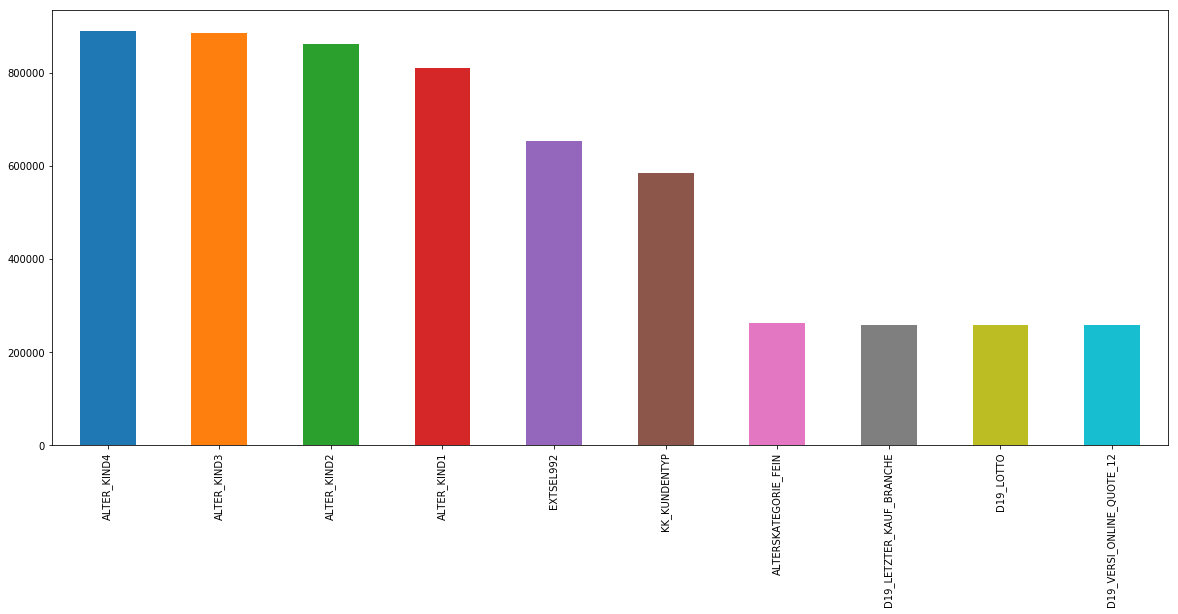

In [20]:
# visualise natually missing data
(azdias_null.sort_values(ascending=False)[:10].plot(kind='bar', figsize=(20,8), fontsize=10))

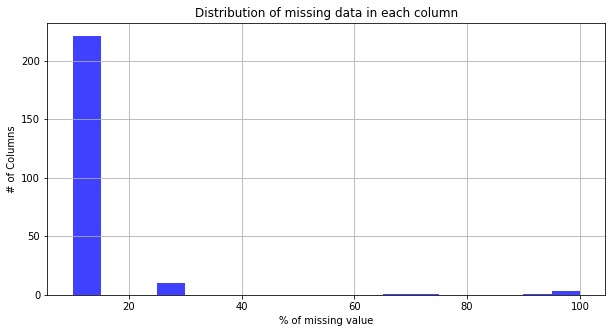

In [21]:
# get dstirbution of empty data in fields by percentage
plt.figure(figsize=(10,5))
plt.hist(azdias_null_percent, bins = np.linspace(10,100,19), facecolor='b', alpha=0.75)


plt.xlabel('% of missing value')
plt.ylabel('# of Columns')
plt.title('Distribution of missing data in each column')
plt.grid(True)

plt.show()

# % of missing data in columns
#print('% of missing data in columns','\n',azdias_null_percent.sort_values(ascending=False))


In [22]:
# above we have already identified %  of nan/null values columnwise
# let's visualise the distribution trend 
column_nans = azdias.isnull().mean()

Text(0.5,0,'prop. of missing values')

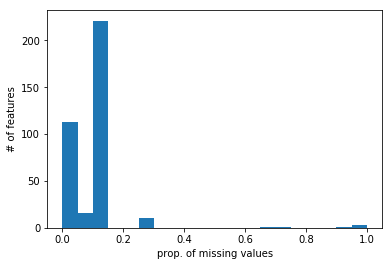

In [23]:


plt.hist(column_nans, bins = np.arange(0,1+.05,.05))
plt.ylabel('# of features')
plt.xlabel('prop. of missing values')

In [24]:
# From review of data in last 2 cells, we can find that % of null data in columns ranges from 0.* to 17% 
# but after that there is drastic difference in % of null fields clearly highlighting outliers. 
# Let's print missing % distribution manually to understand if outlier is evidently visible or further analysis/deep dive required
print('columns having  missing values >0% : ',len(azdias_null_percent[azdias_null_percent>0].index))

print('columns having  missing values >10%: ',len(azdias_null_percent[azdias_null_percent>10].index))
print('columns having  missing values >20%: ',len(azdias_null_percent[azdias_null_percent>20].index))
print('columns having  missing values >30%: ',len(azdias_null_percent[azdias_null_percent>30].index))
print('columns having  missing values >40%: ',len(azdias_null_percent[azdias_null_percent>40].index))
print('columns having  missing values >60%: ',len(azdias_null_percent[azdias_null_percent>60].index))
print('columns having  missing values >65%: ',len(azdias_null_percent[azdias_null_percent>65].index))
print('columns having  missing values >80%: ',len(azdias_null_percent[azdias_null_percent>80].index))
print('columns having  missing values >90%: ',len(azdias_null_percent[azdias_null_percent>90].index))

columns having  missing values >0% :  273
columns having  missing values >10%:  237
columns having  missing values >20%:  16
columns having  missing values >30%:  6
columns having  missing values >40%:  6
columns having  missing values >60%:  6
columns having  missing values >65%:  6
columns having  missing values >80%:  4
columns having  missing values >90%:  4


Text(0.5,0,'# of missing values')

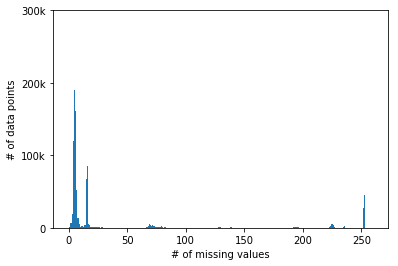

In [25]:
# distribution analysis on row level

row_nans = azdias.isnull().sum(axis=1)
plt.hist(row_nans, bins = np.arange(-0.5,row_nans.max()+1,1))
plt.yticks(np.arange(0,300000+100000,100000),['0','100k','200k','300k'])
plt.ylabel('# of data points')
plt.xlabel('# of missing values')

Text(0.5,0,'# of missing values')

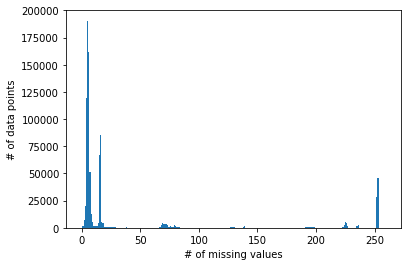

In [26]:
# as 0 has most of the data, we are unable to see rest of the trend in detail. So plotting distribution without 0 missin values
# from below chart we can that around 9ish trend starts changing.

row_nans = azdias[azdias.isnull().sum(axis=1) > 0].isnull().sum(axis=1)
plt.hist(row_nans, bins = np.arange(-0.5,row_nans.max()+1,1))
plt.ylabel('# of data points')
plt.xlabel('# of missing values')

In [27]:
# let's see this in a slightly different way.
# Calculate percentage of data kept for rows with * or less missing data points
# from below we can see that % of data kept for rows with various number of missing data points (in asc order)
# from this we can see that around 16% this more or less stagnates and increase in number of columns does not directly increase % of data kept.
# so we will use this as an indicator to help us choose the threshold limit.

print("Percentage of data kept:",round(azdias.isnull().sum(axis=1).value_counts().sort_index().cumsum()[:30]/azdias.isnull().sum(axis=1).shape[0]*100,0))

Percentage of data kept: 0      0.0
1      0.0
2      1.0
3      3.0
4     17.0
5     38.0
6     56.0
7     62.0
8     63.0
9     64.0
10    64.0
11    64.0
12    65.0
13    65.0
14    65.0
15    73.0
16    82.0
17    83.0
18    83.0
19    83.0
20    84.0
21    84.0
22    84.0
23    84.0
24    84.0
25    84.0
26    84.0
27    84.0
28    84.0
29    84.0
dtype: float64


In [28]:
azdias_bkp = azdias
customers_bkp = customers

## Data Preprocessing

In [8]:
def data_pre_processing(df, for_clustering, df_name=None):
    
    if for_clustering:
        if df_name == 'azdias':
            df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        elif df_name == 'customers':            
            df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    #column_nans = df.isnull().mean()
    drop_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']
    
    df = df.drop(drop_cols,axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)


    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    # drop columns from df
    df = df.drop(drop_columns, axis=1)
    print('shape after corr', df.shape)


    # we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)



    # fillna with 9 for fields that has 9 marked as unknown
    df[df.columns[(df==9).any()]] = df[df.columns[(df==9).any()]].fillna(9)

    # fillna with 0 for fields that has 0 marked as unknown
    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)

    # fillna with -1 for fields that has 0 marked as unknown
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)


    
    #print('col name before: ', df.columns)
    #with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding
    df = pd.get_dummies(df)
    #print('col name after: ', df.columns)
    print('shape after one-hot', df.shape)
    
    df_columns = list(df.columns.values)

    # impute nans using mode value
    imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df)
    #print('imputed dataframe: ', df.head(5))
    print('shape after impute', df.shape)    
    
    # convert to int
    df = df.astype(int)

    # detect and exclude outliers in dataframe
    # as mentioned in https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    #  remove all rows that have outliers in at least one column   
    if for_clustering:
        #print('inside outliers if')
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 
        print('shape before scaling', df.shape)
    # scale the data
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    print('shape after scaling', df.shape)
    #else:
    #    df.columns = df_columns
        
    df = df.set_index('LNR')
    return df

#### clean

In [8]:
%%time
azdias = data_pre_processing(azdias, True, 'azdias')
print(azdias.shape)
#print(azdias.head(5))

shape after corr (733227, 238)
shape after one-hot (733227, 284)
shape after impute (733227, 284)
inside outliers if
shape before scaling (415405, 284)
shape after scaling (415405, 284)
(415405, 283)
CPU times: user 19min 45s, sys: 1min 26s, total: 21min 11s
Wall time: 29min 32s


In [ ]:
#azdias.to_pickle('azdias-scaled.pickle.gzde', compression='gzip')

In [6]:
azdias = pd.read_pickle('azdias-scaled.pickle.gzde', compression='gzip')
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 415405 entries, 1.04452650923 to 0.716892362508
Columns: 283 entries, AGER_TYP to OST_WEST_KZ_W
dtypes: float64(283)
memory usage: 900.1 MB


In [7]:
%%time
customers = data_pre_processing(customers, True, 'customers')
print(customers.shape)
#print(customers.head(5))

shape after corr (191652, 256)
shape after one-hot (191652, 303)
shape after impute (191652, 303)
inside outliers if
shape before scaling (100341, 303)
shape after scaling (100341, 303)
(100341, 302)
CPU times: user 1min 31s, sys: 8.83 s, total: 1min 40s
Wall time: 1min 46s


In [ ]:
#customers.to_pickle('customers-scaled.pickle.gzde', compression='gzip')

In [32]:
customers = pd.read_pickle('customers-scaled.pickle.gzde', compression='gzip')

In [33]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 100341 entries, -1.55636142089 to 1.06623660609
Columns: 302 entries, AGER_TYP to OST_WEST_KZ_W
dtypes: float64(302)
memory usage: 232.0 MB


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [7]:
%%time
pca = PCA().fit(azdias)

CPU times: user 2min 5s, sys: 4.02 s, total: 2min 9s
Wall time: 2min 21s


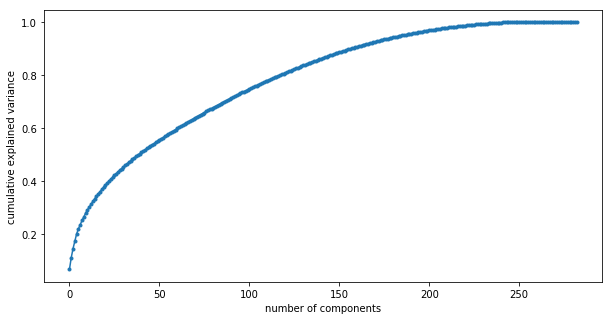

In [8]:
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='.')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [9]:
def print_weights(n):
    '''
    n: number of principal component
    '''
    components = pd.DataFrame(np.round(pca.components_[n - 1: n], 4), columns = azdias.keys())
    components.index = ['Weights']
    components = components.sort_values(by = 'Weights', axis = 1, ascending=False)
    components = components.T
    print(components)
    return components

In [40]:
def reduce_data(df,n=220):
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [11]:
%%time
reduced_azdias = reduce_data(azdias)

0.986960833081
0.997357857317
CPU times: user 3min 12s, sys: 16 s, total: 3min 28s
Wall time: 4min 17s


In [41]:
%%time
reduced_customers = reduce_data(customers)

0.997358620805
CPU times: user 34.5 s, sys: 2.28 s, total: 36.8 s
Wall time: 37.2 s


In [12]:
print('number of rows in new dataset: ',reduced_azdias.shape)
print('number of rows in new dataset: ',reduced_customers.shape)

number of rows in new dataset:  (415405, 220)
number of rows in new dataset:  (100341, 220)


In [13]:
#dont use #700mb
#reduced_azdias.to_pickle('reduced_azdias.pickle.gzde', compression = 'gzip')
#reduced_customers.to_pickle('reduced_customers.pickle.gzde', compression = 'gzip')

In [14]:
#reduced_azdias = pd.read_pickle("reduced_azdias.pickle.gzde", compression = 'gzip')

In [1]:
#reduced_customers = pd.read_pickle("reduced_customers.pickle.gzde", compression = 'gzip')

In [16]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

In [17]:
%%time
scores = []
for i in range(1, 21):
    scores.append(score(reduced_azdias.sample(20000), i))
centers = np.linspace(1,20,20)


CPU times: user 4min 50s, sys: 10.2 s, total: 5min
Wall time: 5min 2s


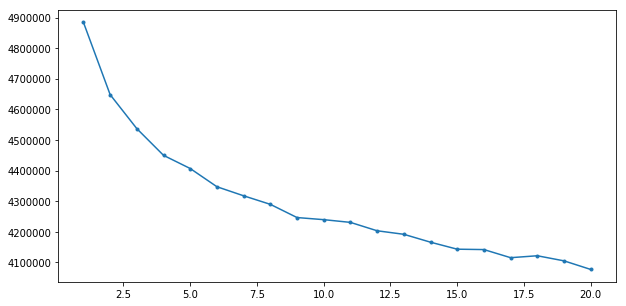

In [18]:
plt.figure(figsize=(10,5))
plt.plot(centers, scores, marker=".")

Text(0.5,0,'Number of Clusters')

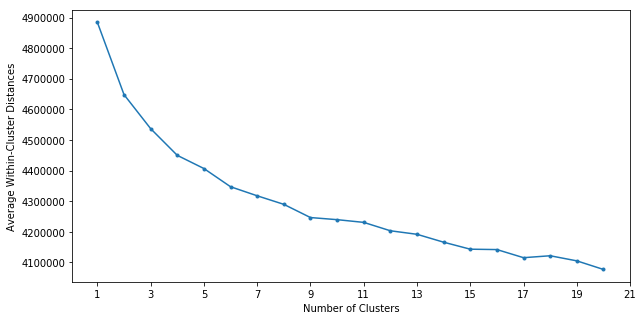

In [19]:
centers = np.linspace(1,20,20)
plt.figure(figsize=(10,5))
plt.plot(centers, scores, marker=".")
plt.xticks(list(range(1,22,2)))
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

In [20]:
%%time
kmeans_k = KMeans(12)
model_k = kmeans_k.fit(reduced_azdias)
prediction_azdias = model_k.predict(reduced_azdias)

CPU times: user 8min 31s, sys: 1min 23s, total: 9min 54s
Wall time: 11min 22s


In [21]:
azdias_clustered = pd.DataFrame(prediction_azdias, columns = ['Cluster'])

In [22]:
#azdias_clustered.to_pickle('azdias_clustered.pickle.gzde', compression = 'gzip')

In [23]:
#azdias_clustered  = pd.read_pickle(azdias_clustered.pickle.gzde', compression = 'gzip')

In [24]:
prediction_customers = model_k.predict(reduced_customers)
customers_clustered = pd.DataFrame(prediction_customers, columns = ['Cluster'])

In [25]:
#customers_clustered.to_pickle('customers_clustered.pickle.gzde', compression = 'gzip')

In [37]:
customers_clustered = pd.read_pickle('customers_clustered.pickle.gzde', compression = 'gzip')

Analysis of data in clusters and also comparison between clusters of general population and customer data

In [27]:
# For each customer segment count the number of predictions  
customer_clusters = pd.Series(prediction_customers)
cc = customer_clusters.value_counts().sort_index()
# Count number in each population segment
population_clusters = pd.Series(prediction_azdias)
pc = population_clusters.value_counts().sort_index()

In [28]:
# Dataframe from population and customer segments
df_stat = pd.concat([pc, cc], axis=1).reset_index()
df_stat.columns = ['cluster','population','customer']

df_stat_cust = df_stat['customer']/df_stat['customer'].sum()*100
df_stat_popu = df_stat['population']/df_stat['population'].sum()*100
df_stat['difference'] = df_stat_cust - df_stat_popu
df_stat

,cluster,population,customer,difference
0,0,52375,30,-12.578280
1,1,33600,46315,38.069111
2,2,36159,6628,-2.099042
3,3,45504,2619,-8.344030
4,4,34985,851,-7.573794
5,5,14962,7236,3.609623
6,6,37971,21916,12.700802
7,7,1728,7,-0.409003
8,8,51243,351,-11.985865
9,9,26305,1018,-5.317834


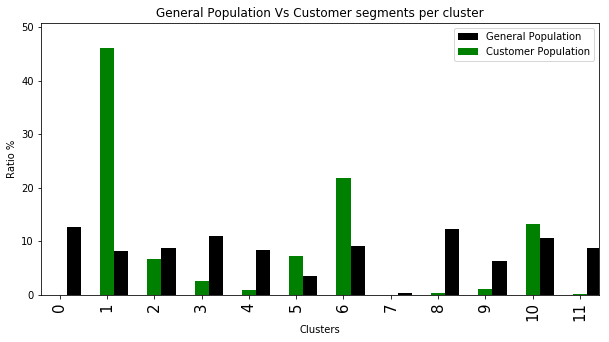

In [29]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Add ratio and ratio difference for each cluster to the dataframe
df_stat['pop_percent'] = df_stat_popu.round(2)
df_stat['cust_percent'] = df_stat_cust.round(2)


fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax = df_stat['pop_percent'].plot(x=df_stat['cluster'],width=0.3,align='edge',color='black',kind='bar',position=0)
ax = df_stat['cust_percent'].plot(width=0.3,align='edge',color='green',kind='bar',position=1)
ax.set_xlabel('Clusters', fontsize=10) 
ax.set_ylabel('Ratio %', fontsize=10)
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 15)
ax.margins(x=0.5,y=0.1)

plt.legend(('General Population', 'Customer Population'),fontsize=10)
plt.title(('General Population Vs Customer segments per cluster'))
plt.show()


In [30]:
# Show Highest Positive and Negative weights when a PComponent and Weight is passed
def pca_weights(pc,weight_num):
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = azdias.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1,  join_axes=[ratio.index])
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Negative weights:")
    print(result.iloc[(pc)-1].sort_values()[:weight_num])

In [31]:
# Show highest positive and negative weights for 5 cluster (over representation of Customer)
pca_weights(5,5)

Principal Component:  5


Highest Positive weights:
KBA13_KMH_210          0.223
OST_WEST_KZ_O          0.187
KBA13_CCM_1401_2500    0.183
KBA13_VORB_0           0.135
KBA13_CCM_2000         0.134
Name: 4, dtype: float64


Negative weights:
KBA13_KW_0_60         -0.239
KBA13_KMH_180         -0.196
KBA13_CCM_0_1400      -0.194
OST_WEST_KZ_W         -0.187
KBA13_SEG_MINIWAGEN   -0.159
Name: 4, dtype: float64


In [32]:
# Show lowest positive and negative weights for 10 cluster (under representation of Customer)
pca_weights(10,5)

Principal Component:  10


Highest Positive weights:
KBA05_MAXSEG     0.272
KBA05_KRSOBER    0.208
KBA05_CCM3       0.186
KBA05_HERST1     0.165
KBA05_KW2        0.163
Name: 9, dtype: float64


Negative weights:
KBA05_CCM1        -0.235
KBA05_MODTEMP     -0.210
KBA05_HERST3      -0.162
OST_WEST_KZ_W     -0.148
KBA05_HERSTTEMP   -0.137
Name: 9, dtype: float64


In [33]:
# scale the data
scale = StandardScaler(copy=False)

In [34]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Analysis of principal components of cluster 2 with over-representation in customer segment.
CC = model_k.cluster_centers_[2]
CC = pd.Series(CC)
CC.index = CC.index +1
print(CC.sort_values(ascending=False).head(5))
print(CC.shape)

1     3.692703
3     3.641263
2     0.704566
4     0.659195
19    0.456817
dtype: float64
(220,)


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [4]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [10]:
# preprocess data
df_mailout_train  = data_pre_processing(X, False)

shape after corr (42962, 253)
shape after one-hot (42962, 300)
shape after impute (42962, 300)
shape after scaling (42962, 300)


In [11]:
print(df_mailout_train.shape)
print(y.shape)

(42962, 299)
(42962,)


In [12]:
# Split the dataset into Train/Validation/Test
X_train, X_val, y_train, y_val = train_test_split(df_mailout_train, y, stratify=y, test_size=0.2, random_state=42)

In [13]:
%%time
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

[09:13:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1588600955503/work/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2.03 s, sys: 132 ms, total: 2.16 s
Wall time: 2.17 s


In [14]:
pred = xg_reg.predict(X_val)
pred

array([ 0.18259421,  0.18259421,  0.18259421, ...,  0.18259421,
        0.18259421,  0.18259421], dtype=float32)

In [15]:
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, pred)))

ROC score on validation data: 0.5000


## Model Evaluation and Validation
In terms of evaluation metric to use, I have tried accuracy, precision, recall and fscore but due to very high imbalance 
(i.e. In MAILOUT_TRAIN dataset, we can find among 43000 individuals, 
 only 532 people response to the mail-out campaign which means the training data is highly imbalanced.), 
none of these were a good way to measure and then finalised on AUC and ROC as the evaluation metric to proceed.

In [16]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # TODO: Calculate the training time
    #results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # print('unique predictions_train: ', set(predictions_train))
    
    # TODO: Calculate the total prediction time
    #results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    #results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    #results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #results['prec_train'] = precision_score(y_train, predictions_train)
    #results['recall_train'] = recall_score(y_train, predictions_train)
    
    #results['prec_test'] = precision_score(y_test, predictions_test)
    #results['recall_test'] = recall_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    #results['f_train'] = fbeta_score(y_train, predictions_train, beta=1)
        
    # TODO: Compute F-score on the test set which is y_test
    #results['f_test'] = fbeta_score(y_test, predictions_test, beta=1)
       
    # Success
    #print("{} trained on samples.".format(learner.__class__.__name__))
    
    #results['roc'] = roc_auc_score(y_test, predictions_test)
    
    roc = roc_auc_score(y_test, predictions_test)
        
    # Return the results
    return roc

In [17]:
# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=42)
skf.get_n_splits(X, y)

5

In [18]:
alg_abr = AdaBoostRegressor(random_state=42)
alg_gbr = GradientBoostingRegressor(random_state=42)
alg_xgb = XGBRegressor(random_state=42)


result_list = []
for alg in [alg_abr, alg_gbr, alg_xgb]:
    alg_name = alg.__class__.__name__
    
    
    
    j=0
    for train_index, val_index in skf.split(df_mailout_train, y):
    
        j+=1
        #print('Fold {}...'.format(j))
        result = {}  
        result['alg_name'] = alg_name
        result['fold']  =  j
        # Split the data into training and test sets
        X_train, X_val = df_mailout_train.iloc[train_index], df_mailout_train.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        
        
        result['roc'] = train_predict(alg, X_train, y_train, X_val, y_val)
        result_list.append(result)
        print (result)
    
#return result_list    

print('result_list: ', result_list)

{'alg_name': 'AdaBoostRegressor', 'fold': 1, 'roc': 0.7520605681485284}
{'alg_name': 'AdaBoostRegressor', 'fold': 2, 'roc': 0.76112332351690848}
{'alg_name': 'AdaBoostRegressor', 'fold': 3, 'roc': 0.78820888122056743}
{'alg_name': 'AdaBoostRegressor', 'fold': 4, 'roc': 0.72870910578577819}
{'alg_name': 'AdaBoostRegressor', 'fold': 5, 'roc': 0.73072796926347061}
{'alg_name': 'GradientBoostingRegressor', 'fold': 1, 'roc': 0.73311512529708089}
{'alg_name': 'GradientBoostingRegressor', 'fold': 2, 'roc': 0.75193446710469802}
{'alg_name': 'GradientBoostingRegressor', 'fold': 3, 'roc': 0.80506516837943964}
{'alg_name': 'GradientBoostingRegressor', 'fold': 4, 'roc': 0.73210648837819448}
{'alg_name': 'GradientBoostingRegressor', 'fold': 5, 'roc': 0.75577588391979689}
{'alg_name': 'XGBRegressor', 'fold': 1, 'roc': 0.5558291721824401}
{'alg_name': 'XGBRegressor', 'fold': 2, 'roc': 0.60636375250274777}
{'alg_name': 'XGBRegressor', 'fold': 3, 'roc': 0.65723789237767871}
{'alg_name': 'XGBRegressor',

In [19]:
df_scores = pd.DataFrame(result_list)
df_scores

,alg_name,fold,roc
0,AdaBoostRegressor,1,0.752061
1,AdaBoostRegressor,2,0.761123
2,AdaBoostRegressor,3,0.788209
3,AdaBoostRegressor,4,0.728709
4,AdaBoostRegressor,5,0.730728
5,GradientBoostingRegressor,1,0.733115
6,GradientBoostingRegressor,2,0.751934
7,GradientBoostingRegressor,3,0.805065
8,GradientBoostingRegressor,4,0.732106
9,GradientBoostingRegressor,5,0.755776


compare Scores

In [20]:
df_scores.groupby('alg_name')['roc'].mean()

alg_name
AdaBoostRegressor            0.752166
GradientBoostingRegressor    0.755599
XGBRegressor                 0.605846
Name: roc, dtype: float64

## Model hyperparameters optimization: model XGBRegressor

In [21]:
parameters = { 'learning_rate' : [0.1],
                'n_estimators' :[500],
                'reg_alpha' : [0.05],
                'subsample' : [0.6],
                'colsample_bytree' : [0.7],
                'gamma' : [0.2],
                'max_depth' : [3],
                'min_child_weight' : [2],
                'objective' : ['binary:logistic'],
                'scale_pos_weight' : [1],
                'random_state' : [42],
                'scoring' : ['roc_auc']
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
cv = GridSearchCV(alg_xgb, parameters, scoring = 'roc_auc', n_jobs= -1)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = cv.fit(X_train, y_train)

cv.grid_scores_, cv.best_params_, cv.best_score_

# Get the estimator and predict
best_clf = grid_fit.best_estimator_
#predictions = (best_clf.fit(X_train, y_train)).predict(X_test)

best_predictions = best_clf.predict(X_val)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [22]:
roc_auc_score(y_val, best_predictions)

0.70385184921668986

### Test model

In [23]:
alg_test = XGBRegressor(
    learning_rate = 0.1,
    n_estimators = 500,
    reg_alpha = 0.05,
    subsample = 0.6,
    colsample_bytree = 0.7,
    gamma = 0.2,
    max_depth = 3,
    min_child_weight = 2,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 42,
    scoring = 'roc_auc')

In [24]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 0.19.1.


In [25]:
from sklearn.cross_validation import KFold
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

roc_score = []
for train,test in cv.split(X_train,y_train):
    preds = alg_test.fit(X_train,y_train)
    predictions_test = preds.predict(X_val)
    roc_score.append(roc_auc_score(y_val, predictions_test))
    
print(roc_score)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0.70385184921668986, 0.70385184921668986]


## Final model

In [26]:
clf_final = xgb.XGBRegressor(
    objective = 'binary:logistic',
    max_depth = 5,
    min_child_weight = 2,
    learning_rate = 0.01,    
    reg_alpha = 0.05,
    subsample = 0.6,
    colsample_bytree = 0.7,
    gamma = 0.2,    
    scale_pos_weight = 1,
    random_state = 42,
    n_estimators = 500,
    scoring = 'roc_auc')

preds = clf_final.fit(X_train,y_train)
predictions_test = preds.predict(X_val)
print(roc_auc_score(y_val, predictions_test))

0.779217934978


In [27]:
feat_importance = clf_final.feature_importances_
#feat_importance

['D19_SOZIALES' 'BALLRAUM' 'KBA05_KRSVAN' 'KBA13_SEG_GROSSRAUMVANS'
 'D19_BANKEN_DIREKT']
[ 0.0128045   0.00666407  0.00660378  0.00653423  0.0062638 ]


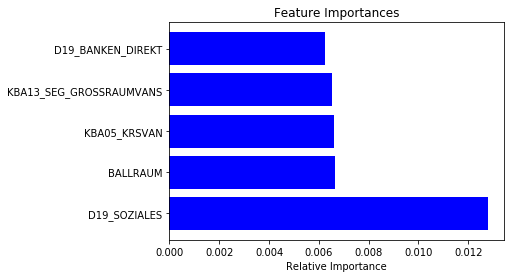

In [28]:
num_feat = 5

indices = np.argsort(feat_importance)[::-1]
columns = X_train.columns.values[indices[:num_feat]]
values = feat_importance[indices][:num_feat]

#print((indices))
print(columns)
print(values)

plt.title('Feature Importances')
plt.barh(np.arange(num_feat), values, color='b', align='center', label = "Feature Weight")
#plt.barh(np.arange(num_feat), np.cumsum(values), color='b', align='center',label = "Cumsum Weight")


plt.yticks(np.arange(num_feat), columns)
plt.xlabel('Relative Importance')
plt.show()

In [29]:
for name, importance in zip(columns, feat_importance):
    print(name, "=", importance)

D19_SOZIALES = 0.00372566
BALLRAUM = 0.00207841
KBA05_KRSVAN = 0.00340579
KBA13_SEG_GROSSRAUMVANS = 0.00406621
D19_BANKEN_DIREKT = 0.00314884


In [30]:
mailout_train['D19_SOZIALES'].unique()

array([  1.,   5.,   2.,   3.,   4.,  nan,   0.])

## Analyse most important feature

In [34]:
customers_pca = PCA(n_components=220).fit(customers)
customers_pca_data = customers_pca.transform(customers)

In [35]:
def get_feature_distance_in_cluster(cluster_number, feature):
    
    # find items in required clustered
    final_items_in_cluster = customers_clustered[customers_clustered['Cluster'] == cluster_number].index
    # get data of items in the identified cluster
    final_reduced_data = reduced_customers.loc[final_items_in_cluster]
    final_data_list = customers_pca.inverse_transform(final_reduced_data)
    final_dataframe = pd.DataFrame(final_data_list, columns=customers.columns.values)
    final_dataframe[feature].hist()

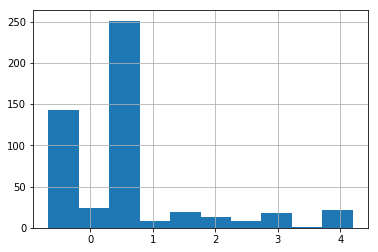

In [42]:
# get 10th cluster of customer data in comparison to general population
get_feature_distance_in_cluster(10, 'D19_SOZIALES')

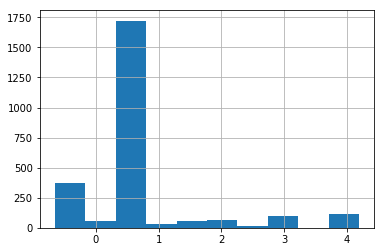

In [43]:
# get 5th cluster of customer data in comparison to general population
get_feature_distance_in_cluster(5, 'D19_SOZIALES')

### To conclude my finding: 
From presented chart of cluster 10 & 5, I observed significance difference in feature "D19_SOZIALES". 
In Cluster 5 the over represented cluster of customer, there is a single bar and in Cluster 10 under represented cluster of customer there is a distribution and not a consolidation in 1 particular value.

## Part 3: Kaggle Competition
Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link here, you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [44]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
# make sure this dataset is not different
missing = list(np.setdiff1d(mailout_train.columns, mailout_test.columns))
missing

['RESPONSE']

In [46]:
print('before preprocessing mailout_test.shape: ', mailout_test.shape)
mailout_test_clean = data_pre_processing(mailout_test, False)
print('after preprocessing mailout_test_clean.shape: ', mailout_test_clean.shape)

before preprocessing mailout_test.shape:  (42833, 366)
shape after corr (42833, 253)
shape after one-hot (42833, 300)
shape after impute (42833, 300)
shape after scaling (42833, 300)
after preprocessing mailout_test_clean.shape:  (42833, 299)


In [47]:
prediction = clf_final.predict(mailout_test_clean)
df = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=prediction)
df.rename(columns={0: "RESPONSE"}, inplace=True)

df.head(10)

,RESPONSE
LNR,
1754,0.034122
1770,0.031593
1465,0.008687
1470,0.008595
1478,0.013780
1782,0.006773
1485,0.007859
1519,0.028045
1835,0.023605


In [48]:
df.to_csv('submission.csv')